In [1]:
import numpy as np
import scipy
from scipy.linalg import sqrtm
import scipy.sparse as sp
from scipy.sparse import coo_matrix, csr_matrix
import matplotlib.pyplot as plt
import networkx as nx
from tqdm import tqdm_notebook as tqdm
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output

from lanczos import lanczos_algorithm, process_adjacency_matrix
from pygcn.pygcn.utils import encode_onehot, normalize, accuracy
from data.loader import load_data
from nn.layers import SpectralConv
from pygcn.pygcn.layers import GraphConvolution

%load_ext autoreload
%autoreload 2
%matplotlib inline
plt.rcParams['figure.figsize'] = (7, 5)

# Quora citation dataset

# Pubmed

# CiteSeer data load

In [2]:
from gcn.gcn.utils import load_data as gcn_load_data
adj, features, labels, idx_train, idx_val, idx_test = load_data('cora') # /cora/citeseer
A = np.array(adj.todense())

## Data processing

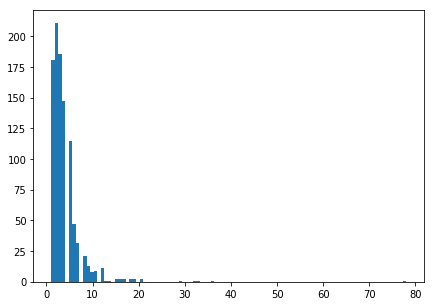

In [3]:
plt.hist(A.sum(0)[:1000], bins=100)
plt.show()

Looks like A is already normalized, and diagonal elements are nonzero. Maybe, we don't even need to calculate S? <br>
UPD. A is slightly worse then S: max accuracy 84.6 in comparison to 84.  

In [30]:
k=20
S, V, R = process_adjacency_matrix(A, k) #need only this one
S, Q, T = process_adjacency_matrix(A, k, ritz=False)

/home/mvkolos/projects/LanczosNet/lanczos.py:50: RuntimeWarning: invalid value encountered in sqrt
  D = np.sqrt(np.linalg.inv(D))
100%|██████████| 20/20 [00:00<00:00, 56.15it/s]


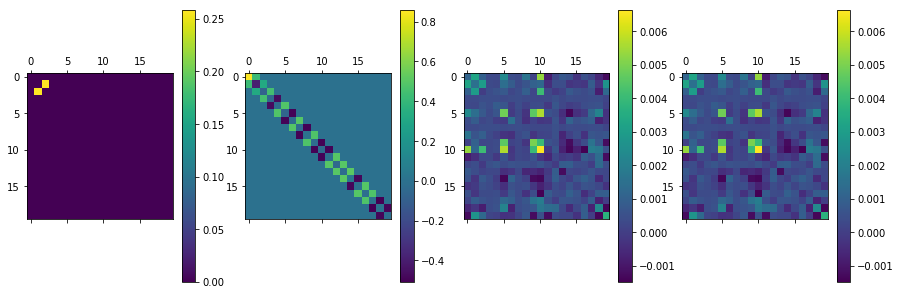

In [31]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 5))
m1 = ax1.matshow(S[:20,:20])
m2 = ax2.matshow(T[:20,:20])
m3 = ax3.matshow((Q@T@Q.T)[:20,:20])
m4 = ax4.matshow((V@R@V.T)[:20,:20])
f.colorbar(m1, ax=ax1)
f.colorbar(m2, ax=ax2)
f.colorbar(m3, ax=ax3)
f.colorbar(m4, ax=ax4)

## Training

In [32]:
class LanczosConvNet(nn.Module):
    def __init__(self, k, feat_dim, num_classes, short_scales, long_scales, out_features = 1024, inner_dim = 256):
        super(LanczosConvNet, self).__init__()
        self.spectral_conv = SpectralConv(feat_dim, out_features, k, short_scales, long_scales, mlp_layers_number=1)
#         self.pool = nn.MaxPool1d(3, stride=2)
        self.conv1 = GraphConvolution(out_features, inner_dim)
        self.conv2 = GraphConvolution(inner_dim, num_classes)
                                      
    def forward(self, adj, X, S, V, R):
        features = self.spectral_conv(X, S, V, R)
#         features = self.pool(features[None, :,:])[0]
#         print(features.shape)
        Z = self.conv1(features, adj)
        Z = self.conv2(Z, adj)        
        
        return F.log_softmax(Z)

In [33]:
n = adj.shape[0]
feat_dim = features.shape[-1]
short_scales = [1,5,7]
long_scales = [10,20,30]
num_classes = len(np.unique(labels))
lr = 1e-2

In [27]:
A = torch.Tensor(A).cuda()
X = features.cuda()
S = torch.Tensor(S).cuda()
V = torch.Tensor(V).cuda()
w = torch.Tensor(np.diag(R)).cuda()
labels = torch.LongTensor(labels).cuda()

TypeError: expected torch.FloatTensor (got torch.cuda.FloatTensor)

In [28]:
loss_train_vals = []
loss_test_vals = []
acc_train_vals = []
acc_test_vals = []

model = LanczosConvNet(k, feat_dim,  num_classes, short_scales, long_scales).cuda()
optimizer = optim.Adam(model.parameters(), lr=lr)

def train(epoch, eval_epoch=3):
    model.train()
    optimizer.zero_grad()
    output = model(A, X, S, V, w)
    loss_train = F.nll_loss(output[idx_train], labels[idx_train])
    acc_train = accuracy(output[idx_train], labels[idx_train])
    loss_train.backward()
    optimizer.step()

    model.eval()
    output = model(A, X, S, V, w)

    loss_val = F.nll_loss(output[idx_val], labels[idx_val])
    acc_val = accuracy(output[idx_val], labels[idx_val])
    
    loss_train_vals.append(loss_train.item())
    loss_test_vals.append(loss_val.item())
    acc_train_vals.append(acc_train.item())
    acc_test_vals.append(acc_val.item())
    
    if epoch > 0 and epoch%eval_epoch == 0:
        
        print('Epoch: {:04d}'.format(epoch+1),
              'loss_train: {:.4f}'.format(loss_train_vals[-1]),
              'acc_train: {:.4f}'.format(acc_train_vals[-1]),
              'loss_val: {:.4f}'.format(loss_test_vals[-1]),
              'acc_val: {:.4f}'.format(acc_test_vals[-1]))


def test():
    model.eval()
    output = model(A, X, S, V, w)
    loss_test = F.nll_loss(output[idx_test], labels[idx_test])
    acc_test = accuracy(output[idx_test], labels[idx_test])
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "accuracy= {:.4f}".format(acc_test.item()))

A Jupyter Widget

/opt/anaconda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 0004 loss_train: 4990.6016 acc_train: 0.2357 loss_val: 2750.9805 acc_val: 0.1640
Epoch: 0007 loss_train: 2619.0261 acc_train: 0.2857 loss_val: 1128.8781 acc_val: 0.3500
Epoch: 0010 loss_train: 1235.5109 acc_train: 0.6214 loss_val: 1099.8651 acc_val: 0.5500
Epoch: 0013 loss_train: 631.9789 acc_train: 0.7071 loss_val: 685.1377 acc_val: 0.6200
Epoch: 0016 loss_train: 239.3647 acc_train: 0.8571 loss_val: 609.4673 acc_val: 0.6940
Epoch: 0019 loss_train: 322.2289 acc_train: 0.8071 loss_val: 753.4612 acc_val: 0.6200
Epoch: 0022 loss_train: 259.0063 acc_train: 0.8143 loss_val: 579.9990 acc_val: 0.7000
Epoch: 0025 loss_train: 157.2566 acc_train: 0.8786 loss_val: 523.2261 acc_val: 0.7260
Epoch: 0028 loss_train: 51.3290 acc_train: 0.9143 loss_val: 544.4069 acc_val: 0.6760
Epoch: 0031 loss_train: 47.4581 acc_train: 0.9000 loss_val: 582.7641 acc_val: 0.6940
Epoch: 0034 loss_train: 33.3463 acc_train: 0.9071 loss_val: 574.7156 acc_val: 0.6620
Epoch: 0037 loss_train: 25.7965 acc_train: 0.9286 l

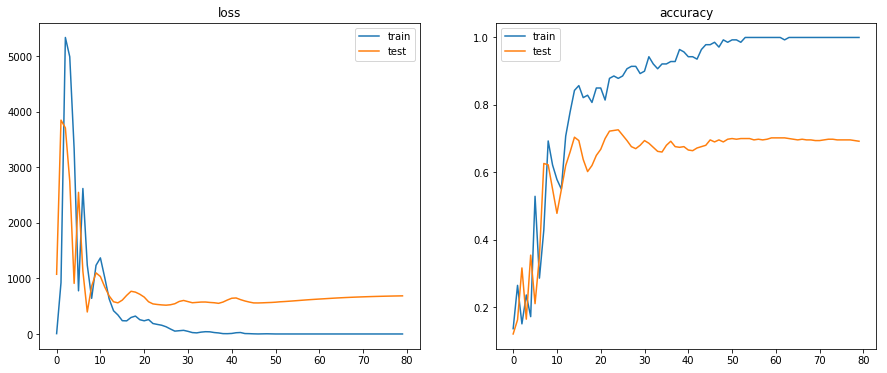

In [29]:
epochs=80
for epoch in tqdm(range(epochs)):
    train(epoch)
print(f'\nmin test loss: \t{loss_test_vals[np.argmin(acc_test_vals)]}')
print(f'max test accuracy: \t{max(acc_test_vals)}')
test()

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
ax1.plot(loss_train_vals, label='train')
ax1.plot(loss_test_vals, label='test')
ax1.set_title('loss')
ax1.legend()

ax2.plot(acc_train_vals, label='train')
ax2.plot(acc_test_vals, label='test')
ax2.set_title('accuracy')
ax2.legend()

plt.show()